In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from pathlib import Path
from scipy import stats
import joblib
%matplotlib inline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import  GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
import xgboost as xgb

from catboost import CatBoostClassifier
import lightgbm as lgb


from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, classification_report, recall_score , confusion_matrix
from sklearn.metrics import roc_curve, auc, fbeta_score, precision_score,  roc_auc_score, roc_curve,  ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek


In [2]:
df_train = pd.read_csv(r'C:\Users\user\Desktop\BIA Insurance Prediction Project\data\df_train_original.csv')
df_test = pd.read_csv(r'C:\Users\user\Desktop\BIA Insurance Prediction Project\data\df_test.csv')

In [3]:
df_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_less__1_Year,Vehicle_Age_greater__2_Years,Response
0,1,1.143065,1,0.063490,0,1,-0.162446,0.548305,-1.293724,0,1,0
1,0,2.301808,1,1.000000,1,0,1.607934,0.548305,0.056257,0,0,0
2,1,0.499320,1,0.316108,0,1,-0.099206,0.548305,0.713327,0,0,0
3,1,-1.110045,1,0.051053,0,1,-1.413451,0.160834,-0.672494,1,0,0
4,0,-0.144426,1,1.000000,0,1,0.330654,0.548305,1.238984,0,0,0


In [4]:
df_test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_less__1_Year,Vehicle_Age_greater__2_Years
0,1,-1.045670,1,168.327264,1,0,2.365986,429.740597,-0.803908,0,1,0
1,0,-0.595048,1,93.116411,0,1,-1.419244,73.508199,-1.508765,1,1,0
2,0,0.628069,1,100.279350,1,0,0.877130,344.923360,-0.170731,0,0,0
3,1,-0.981296,1,128.931103,0,0,0.582598,429.740597,0.438553,0,1,0
4,1,0.306196,1,39.394374,1,0,0.473050,350.577842,1.262877,0,0,0


In [3]:
X_train = df_train.drop(columns='Response', axis = 1)
y_train = df_train['Response']

X_test = df_test.drop(columns='Response', axis = 1)
y_test = df_test['Response']

In [19]:
# SMOTEEK
df_train1 = pd.read_csv(r'C:\Users\user\Desktop\BIA Insurance Prediction Project\data\df_train1.csv')

X_train1 = df_train1.drop(columns='Response', axis = 1)
y_train1 = df_train1['Response']

In [20]:
# SMOTEEN
df_train2 = pd.read_csv(r'C:\Users\user\Desktop\BIA Insurance Prediction Project\data\df_train2.csv')

X_train2 = df_train2.drop(columns='Response', axis = 1)
y_train2 = df_train2['Response']

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score, 
    balanced_accuracy_score, confusion_matrix, fbeta_score, 
    roc_auc_score, ConfusionMatrixDisplay
)

# 1. Initialize the report dictionary
report = {
    'Sampling': [],
    'model_name': [],
    'TP': [],
    'FP': [],
    'TN': [],
    'FN': [],
    'accuracy': [],
    'balanced_accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'f0.5': [],
    'f2.0': [],
    'roc_auc': []
}

# 2. Function to perform sampling
def do_sampling(X, y, sample_type):
    sampler = sample_type()
    return sampler.fit_resample(X, y)

#displays report in a dataframe
def display_report():
  return pd.DataFrame(report)
# 4. Updated Evaluate Function

# function to evaluate and update model and score
def evaluate(technique,modelname, Model, X_train, y_train, X_test, y_test):
  
  a = display_report().copy()
  a['id'] = a['Sampling'] + a['model_name']
  if technique + modelname in a['id'].unique():
    print('Prexisting Model')
    return 0
  X_tr = X_train.copy()
  X_te = X_test.copy()

  print(f"\nTraining {str(Model)} ...")
  Model.fit(X_tr, y_train)

  print(f"\nPredicting{str(Model)} scores ...")

  y_pred = Model.predict(X_te)

  #update f1 score
  f1 = f1_score(y_test,y_pred)
  report['f1'].append(f1)

  #update precision score
  precision = precision_score(y_test,y_pred)
  report['precision'].append(precision)

  #update recall
  recall = recall_score(y_test,y_pred)
  report['recall'].append(recall)

  #update accuracy
  acc = accuracy_score(y_test,y_pred)
  report['accuracy'].append(acc)

  #update balanced accuracy
  blacc = balanced_accuracy_score(y_test,y_pred)
  report['balanced_accuracy'].append(blacc)

  #update TRUE negative,  TRUE positive and false negative, false positive
  tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
  report['TN'].append(tn)
  report['FN'].append(fn)
  report['TP'].append(tp)
  report['FP'].append(fp)

  #F0.5 score
  f_05 = fbeta_score(y_test,y_pred,beta = 0.5)
  report['f0.5'].append(f_05)

  #F2 score 
  f_2 = fbeta_score(y_test,y_pred,beta = 2.0)
  report['f2.0'].append(f_2)

  #auc roc score
  y_pred_proba = Model.predict_proba(X_test)[::,1]
  roc_auc = roc_auc_score(y_test,y_pred_proba)
  report['roc_auc'].append(roc_auc)

  #plotting confusion matrix
  ConfusionMatrixDisplay.from_estimator(Model, X_test, y_test, cmap='Blues')  
  plt.title(modelname.upper())
  plt.show()

  #updating model and training set details
  report['Sampling'].append(technique)
  report['model_name'].append(modelname)





In [5]:
def get_models():
  models, names = list(), list()

  # GNB
  models.append(GaussianNB())
  names.append('Gaussian NaiveBayes')

  # DecisionTreeClassifier
  models.append((DecisionTreeClassifier()))
  names.append('DecisionTree Classifier')

  #RandomForestClassifier
  models.append(RandomForestClassifier())
  names.append('RandomForest Classifier')

  # GradientBoostingClassifier
  models.append(GradientBoostingClassifier())
  names.append('GradientBoosting Classifier')

  #BaggingClassifier
  models.append(BaggingClassifier())
  names.append('Bagging Classifier')

  #XgbClassifier
  models.append(xgb.XGBClassifier())
  names.append('XGBClassifier Classifier')

  #AdaBoostClassifier
  models.append(AdaBoostClassifier())
  names.append('AdaBoostClassifier Classifier')

  #CatBoost Classifier
  models.append(CatBoostClassifier(silent=True))
  names.append('CatBoostClassifier')

  #LGBM
  models.append(lgb.LGBMClassifier())
  names.append('LGBM Classifier')



  return models, names

### Unsampled


Training GaussianNB() ...

PredictingGaussianNB() scores ...


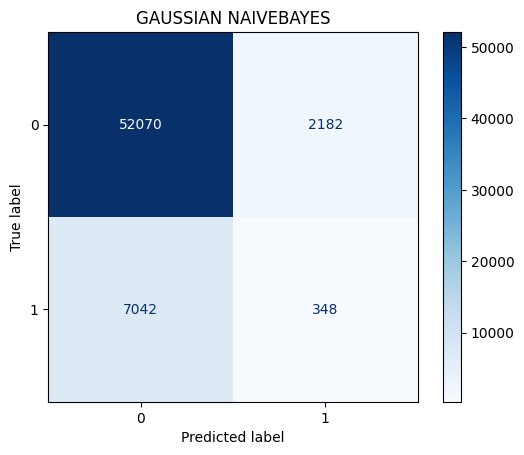


Training DecisionTreeClassifier() ...

PredictingDecisionTreeClassifier() scores ...


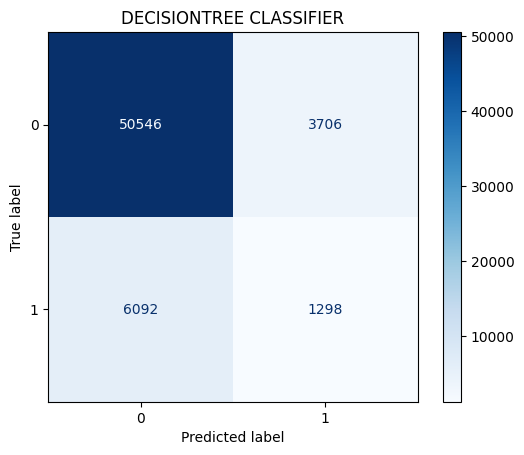


Training RandomForestClassifier() ...

PredictingRandomForestClassifier() scores ...


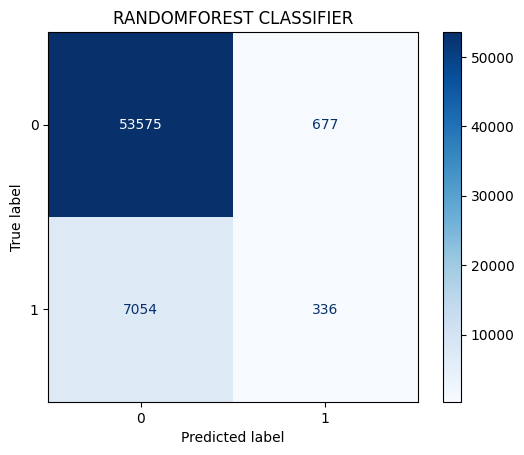


Training GradientBoostingClassifier() ...

PredictingGradientBoostingClassifier() scores ...


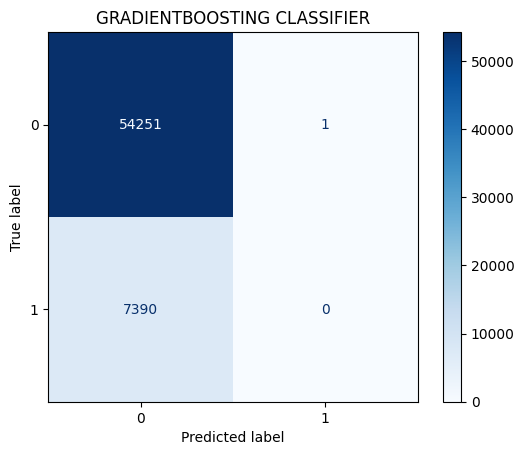


Training BaggingClassifier() ...

PredictingBaggingClassifier() scores ...


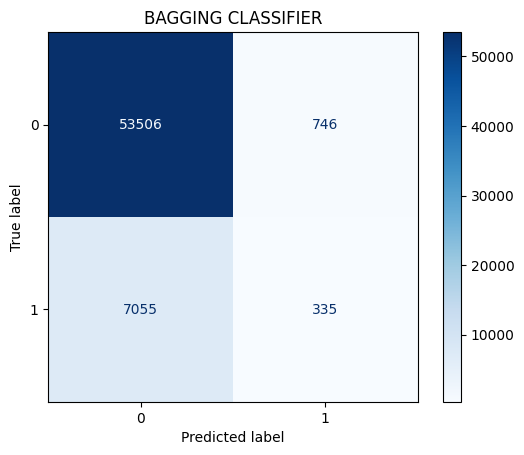


Training XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) ...

PredictingXGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              

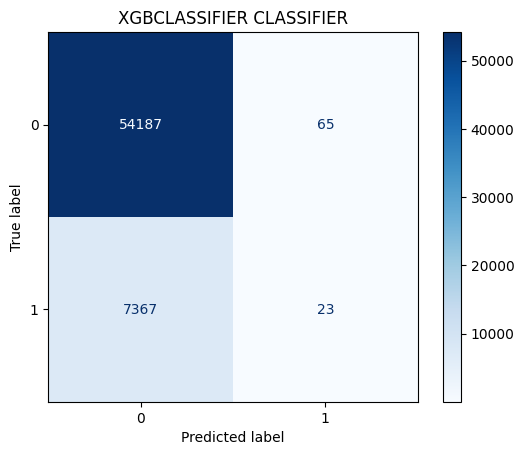


Training AdaBoostClassifier() ...

PredictingAdaBoostClassifier() scores ...


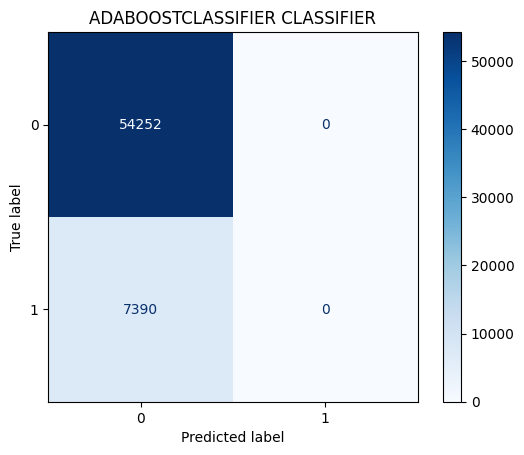


Training <catboost.core.CatBoostClassifier object at 0x000001B422FC9B10> ...

Predicting<catboost.core.CatBoostClassifier object at 0x000001B422FC9B10> scores ...


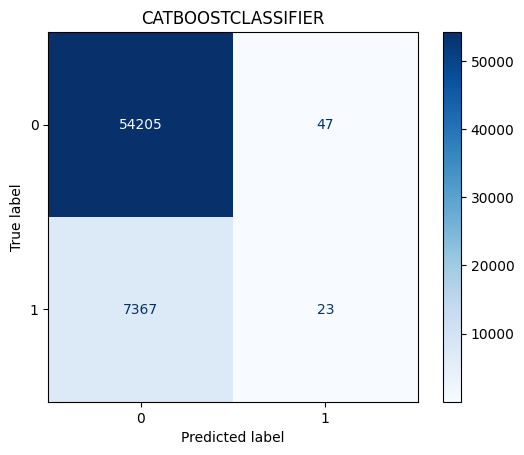


Training LGBMClassifier() ...
[LightGBM] [Info] Number of positive: 29567, number of negative: 216816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 246383, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120004 -> initscore=-1.992390
[LightGBM] [Info] Start training from score -1.992390

PredictingLGBMClassifier() scores ...


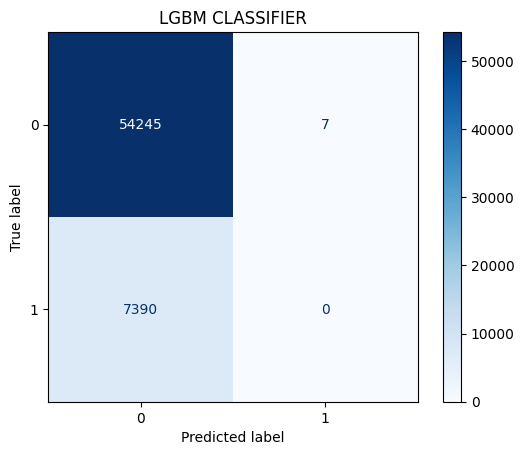

,Sampling,model_name,TP,FP,TN,FN,accuracy,balanced_accuracy,recall,precision,f1,f0.5,f2.0,roc_auc
0,None,Gaussian NaiveBayes,348,2182,52070,7042,0.850362,0.503435,0.047091,0.137549,0.070161,0.099372,0.054222,0.503393
1,None,DecisionTree Classifier,1298,3706,50546,6092,0.841050,0.553666,0.175643,0.259392,0.209456,0.236809,0.187768,0.553666
2,None,RandomForest Classifier,336,677,53575,7054,0.874582,0.516494,0.045467,0.331688,0.079971,0.146827,0.054950,0.805645
3,None,GradientBoosting Classifier,0,1,54251,7390,0.880098,0.499991,0.000000,0.000000,0.000000,0.000000,0.000000,0.846993
4,None,Bagging Classifier,335,746,53506,7055,0.873447,0.515790,0.045332,0.309898,0.079093,0.142991,0.054665,0.723983
5,None,XGBClassifier Classifier,23,65,54187,7367,0.879433,0.500957,0.003112,0.261364,0.006151,0.014854,0.003879,0.816254
6,None,AdaBoostClassifier Classifier,0,0,54252,7390,0.880114,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.851738
7,None,CatBoostClassifier,23,47,54205,7367,0.879725,0.501123,0.003112,0.328571,0.006166,0.014993,0.003881,0.824994
8,None,LGBM Classifier,0,7,54245,7390,0.880001,0.499935,0.000000,0.000000,0.000000,0.000000,0.000000,0.817112


In [6]:
models, names = get_models()
for i in range(len(models)):
  evaluate("None", names[i], models[i],X_train, y_train, X_test,y_test)
display_report()


Training GaussianNB() ...

PredictingGaussianNB() scores ...


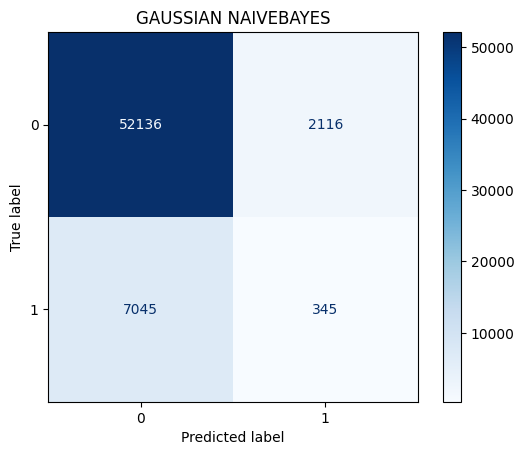


Training DecisionTreeClassifier() ...

PredictingDecisionTreeClassifier() scores ...


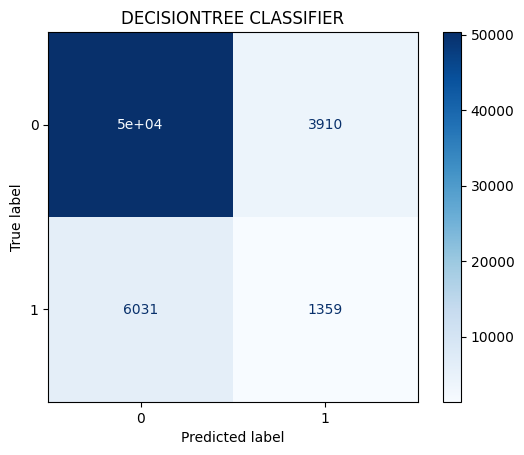


Training RandomForestClassifier() ...

PredictingRandomForestClassifier() scores ...


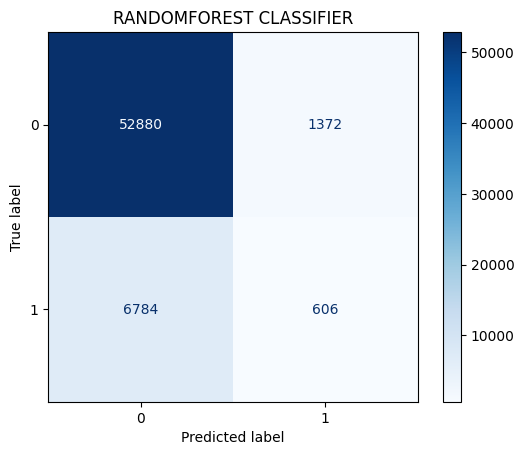


Training GradientBoostingClassifier() ...

PredictingGradientBoostingClassifier() scores ...


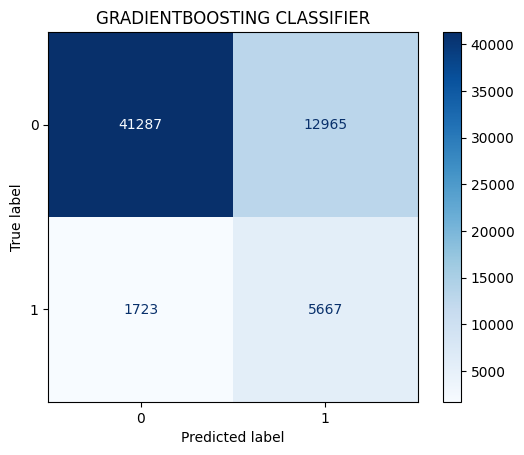


Training BaggingClassifier() ...

PredictingBaggingClassifier() scores ...


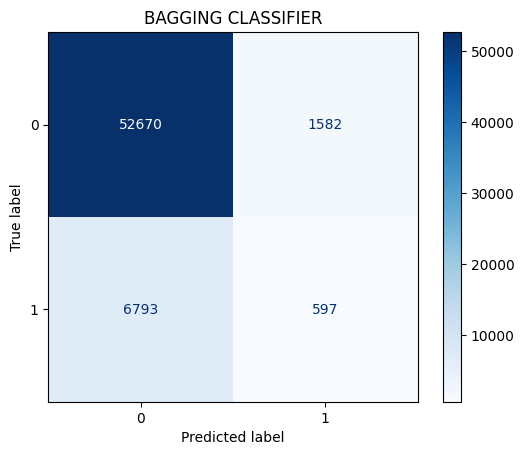


Training XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) ...

PredictingXGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              

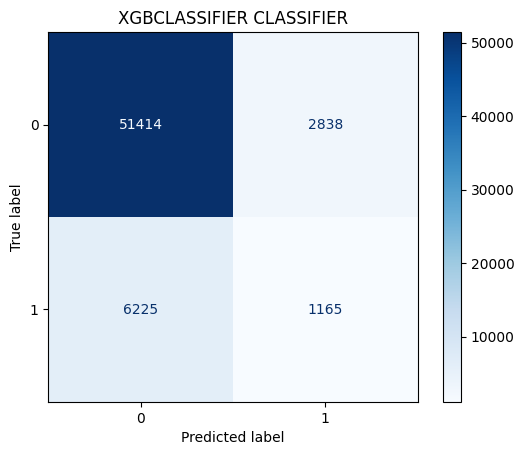


Training AdaBoostClassifier() ...

PredictingAdaBoostClassifier() scores ...


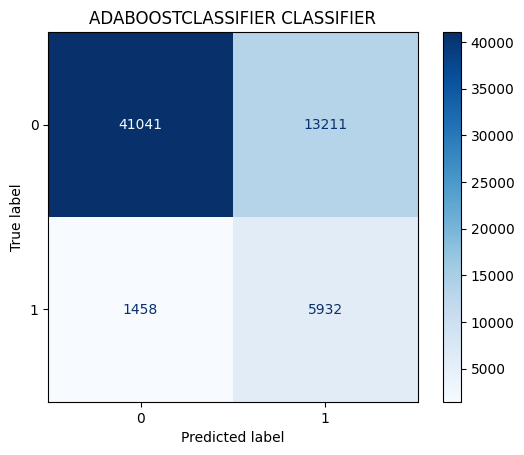


Training <catboost.core.CatBoostClassifier object at 0x000001B422FC85B0> ...

Predicting<catboost.core.CatBoostClassifier object at 0x000001B422FC85B0> scores ...


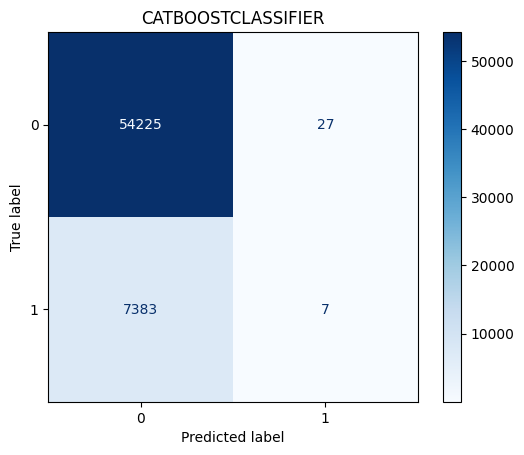


Training LGBMClassifier() ...
[LightGBM] [Info] Number of positive: 216816, number of negative: 216816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 433632, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

PredictingLGBMClassifier() scores ...


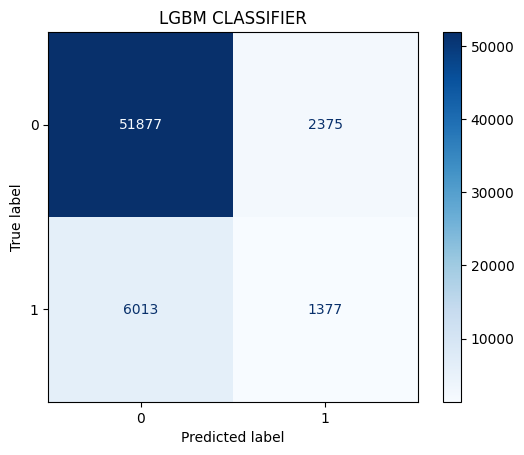

,Sampling,model_name,TP,FP,TN,FN,accuracy,balanced_accuracy,recall,precision,f1,f0.5,f2.0,roc_auc
0,None,Gaussian NaiveBayes,348,2182,52070,7042,0.850362,0.503435,0.047091,0.137549,0.070161,0.099372,0.054222,0.503393
1,None,DecisionTree Classifier,1298,3706,50546,6092,0.841050,0.553666,0.175643,0.259392,0.209456,0.236809,0.187768,0.553666
2,None,RandomForest Classifier,336,677,53575,7054,0.874582,0.516494,0.045467,0.331688,0.079971,0.146827,0.054950,0.805645
3,None,GradientBoosting Classifier,0,1,54251,7390,0.880098,0.499991,0.000000,0.000000,0.000000,0.000000,0.000000,0.846993
4,None,Bagging Classifier,335,746,53506,7055,0.873447,0.515790,0.045332,0.309898,0.079093,0.142991,0.054665,0.723983
5,None,XGBClassifier Classifier,23,65,54187,7367,0.879433,0.500957,0.003112,0.261364,0.006151,0.014854,0.003879,0.816254
6,None,AdaBoostClassifier Classifier,0,0,54252,7390,0.880114,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.851738
7,None,CatBoostClassifier,23,47,54205,7367,0.879725,0.501123,0.003112,0.328571,0.006166,0.014993,0.003881,0.824994
8,None,LGBM Classifier,0,7,54245,7390,0.880001,0.499935,0.000000,0.000000,0.000000,0.000000,0.000000,0.817112
9,SMOTE Sampling,Gaussian NaiveBayes,345,2116,52136,7045,0.851384,0.503841,0.046685,0.140187,0.070044,0.100093,0.053871,0.504199


In [7]:
# Smote sampled

X_smote, y_smote = do_sampling(X_train, y_train, SMOTE)

models, names = get_models()
for i in range(len(models)):
  evaluate("SMOTE Sampling", names[i],models[i],X_smote, y_smote, X_test,y_test)
display_report()


Training GaussianNB() ...

PredictingGaussianNB() scores ...


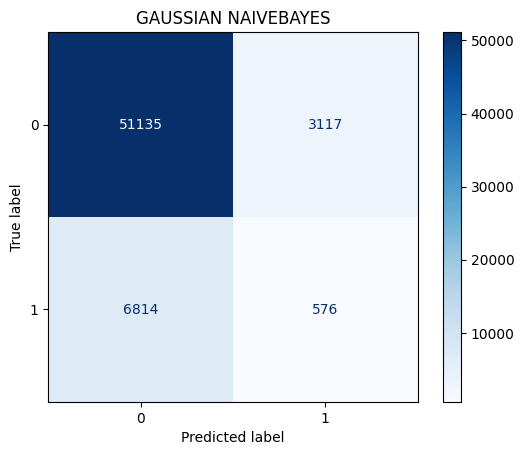


Training DecisionTreeClassifier() ...

PredictingDecisionTreeClassifier() scores ...


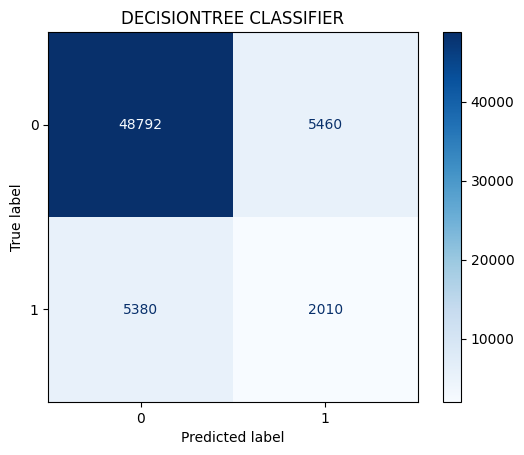


Training RandomForestClassifier() ...

PredictingRandomForestClassifier() scores ...


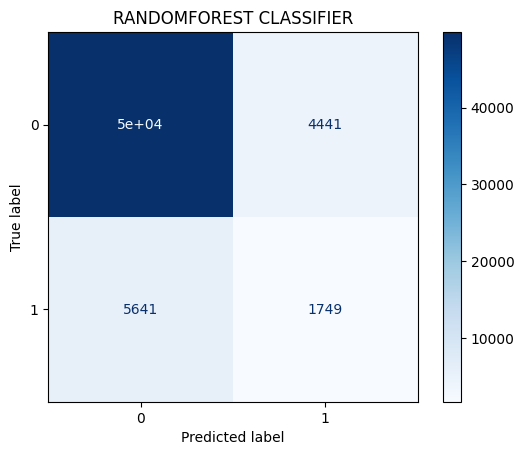


Training GradientBoostingClassifier() ...

PredictingGradientBoostingClassifier() scores ...


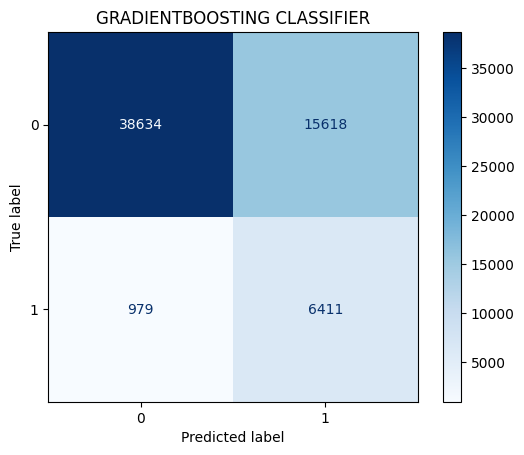


Training BaggingClassifier() ...

PredictingBaggingClassifier() scores ...


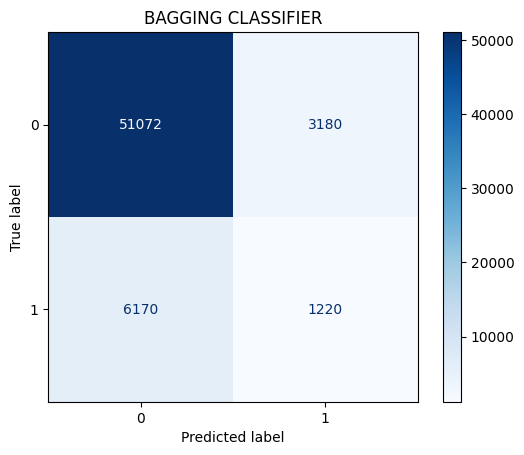


Training XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) ...

PredictingXGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              

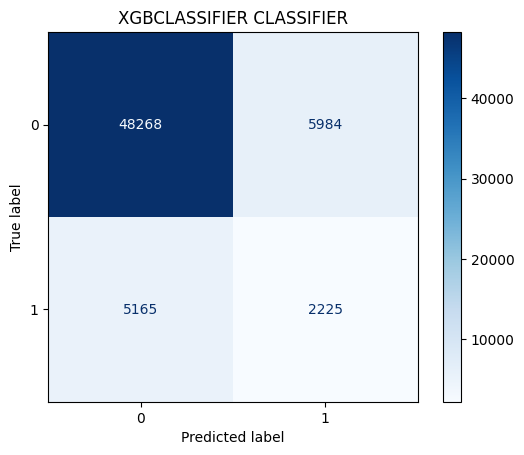


Training AdaBoostClassifier() ...

PredictingAdaBoostClassifier() scores ...


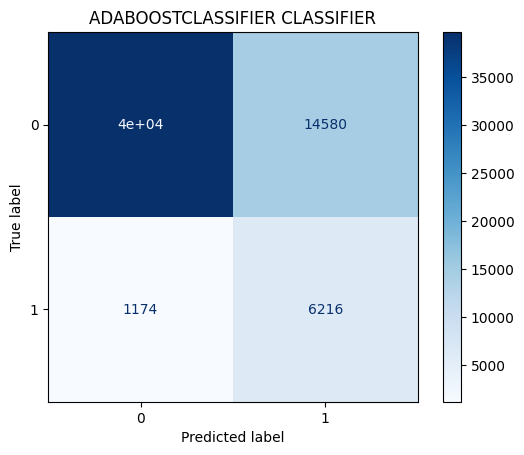


Training <catboost.core.CatBoostClassifier object at 0x000001B42E11E650> ...

Predicting<catboost.core.CatBoostClassifier object at 0x000001B42E11E650> scores ...


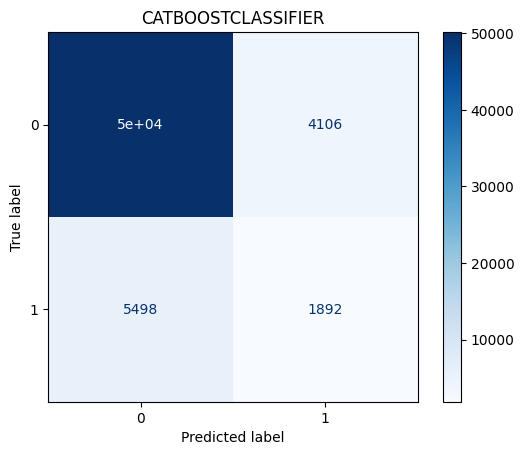


Training LGBMClassifier() ...
[LightGBM] [Info] Number of positive: 193366, number of negative: 158507
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 351873, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549533 -> initscore=0.198786
[LightGBM] [Info] Start training from score 0.198786

PredictingLGBMClassifier() scores ...


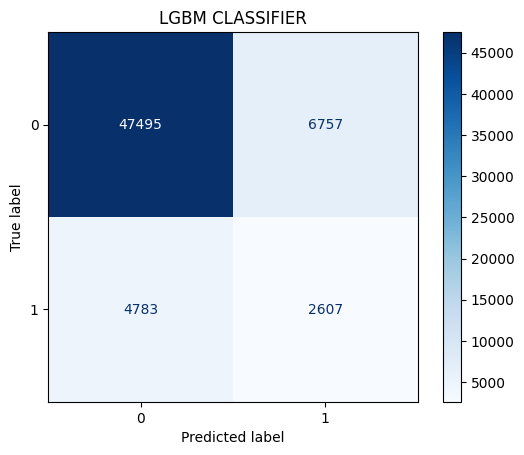

,Sampling,model_name,TP,FP,TN,FN,accuracy,balanced_accuracy,recall,precision,f1,f0.5,f2.0,roc_auc
0,None,Gaussian NaiveBayes,348,2182,52070,7042,0.850362,0.503435,0.047091,0.137549,0.070161,0.099372,0.054222,0.503393
1,None,DecisionTree Classifier,1298,3706,50546,6092,0.841050,0.553666,0.175643,0.259392,0.209456,0.236809,0.187768,0.553666
2,None,RandomForest Classifier,336,677,53575,7054,0.874582,0.516494,0.045467,0.331688,0.079971,0.146827,0.054950,0.805645
3,None,GradientBoosting Classifier,0,1,54251,7390,0.880098,0.499991,0.000000,0.000000,0.000000,0.000000,0.000000,0.846993
4,None,Bagging Classifier,335,746,53506,7055,0.873447,0.515790,0.045332,0.309898,0.079093,0.142991,0.054665,0.723983
5,None,XGBClassifier Classifier,23,65,54187,7367,0.879433,0.500957,0.003112,0.261364,0.006151,0.014854,0.003879,0.816254
6,None,AdaBoostClassifier Classifier,0,0,54252,7390,0.880114,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.851738
7,None,CatBoostClassifier,23,47,54205,7367,0.879725,0.501123,0.003112,0.328571,0.006166,0.014993,0.003881,0.824994
8,None,LGBM Classifier,0,7,54245,7390,0.880001,0.499935,0.000000,0.000000,0.000000,0.000000,0.000000,0.817112
9,SMOTE Sampling,Gaussian NaiveBayes,345,2116,52136,7045,0.851384,0.503841,0.046685,0.140187,0.070044,0.100093,0.053871,0.504199


In [8]:
# Smoteen sampled

X_smote, y_smote = do_sampling(X_train, y_train, SMOTEENN)

models, names = get_models()
for i in range(len(models)):
  evaluate("SMOTEen Sampling", names[i],models[i],X_smote, y_smote, X_test,y_test)
display_report()

In [56]:
final_report.sort_values([ 'f2.0'], ascending = False).head(5)

,Sampling,model_name,TP,FP,TN,FN,accuracy,balanced_accuracy,recall,precision,f1,f0.5,f2.0,roc_auc
0,None,LogisticRegression,7389,52964,1288,1,0.140764,0.511803,0.999865,0.122430,0.218148,0.148492,0.410897,0.599152
2,None,DecisionTree Classifier,1276,3778,50474,6114,0.839525,0.551514,0.172666,0.252473,0.205079,0.231109,0.184318,0.551514
5,None,Bagging Classifier,480,1250,53002,6910,0.867623,0.520956,0.064953,0.277457,0.105263,0.167715,0.076702,0.716939
3,None,RandomForest Classifier,438,1009,53243,6952,0.870851,0.520335,0.059269,0.302695,0.099129,0.166186,0.070629,0.806410
1,None,Gaussian NaiveBayes,347,2172,52080,7043,0.850508,0.503460,0.046955,0.137753,0.070037,0.099336,0.054085,0.504210


In [57]:
a = final_report.copy()
a['Name'] = a['Sampling'] + a['model_name']

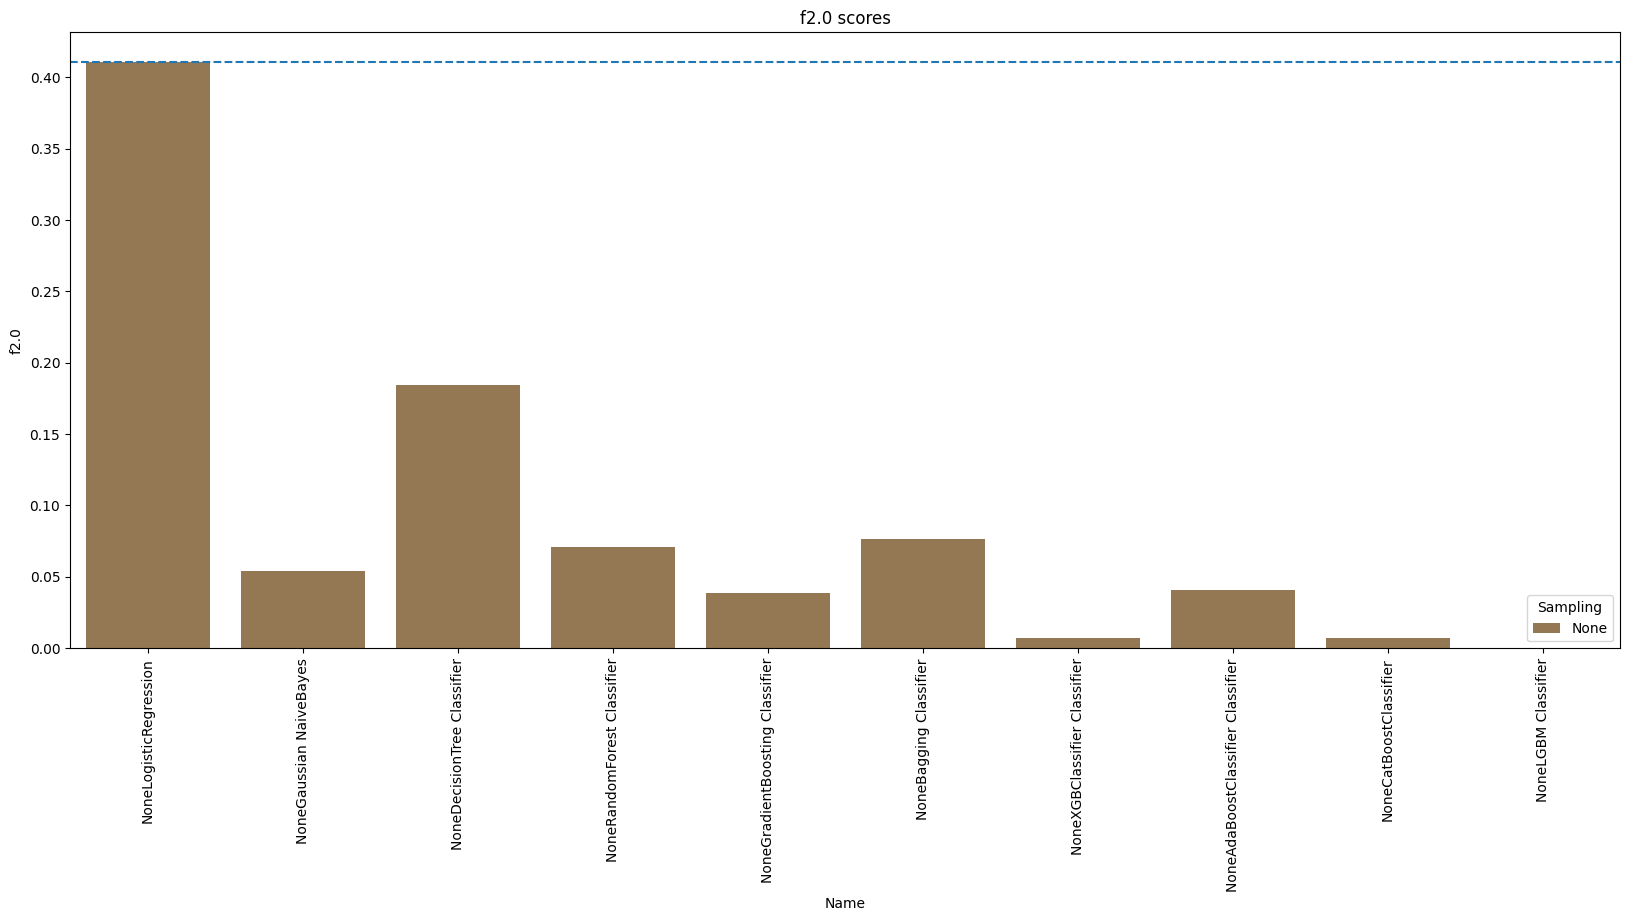

In [58]:
metrics = ['f2.0']
for i in metrics:
  print('\n')
  plt.figure(figsize = (20,8))
  sns.barplot( y = i, x = 'Name',hue = 'Sampling' ,data=a, palette = 'cubehelix_r',dodge=False)
  plt.yticks(ticks = np.arange(0,final_report[i].max(), .05 ))
  plt.xticks(rotation =90)
  plt.axhline(y = final_report[i].max(), ls = '--')
  plt.title(f"{i} scores")
  plt.show()



Training GaussianNB() ...

PredictingGaussianNB() scores ...


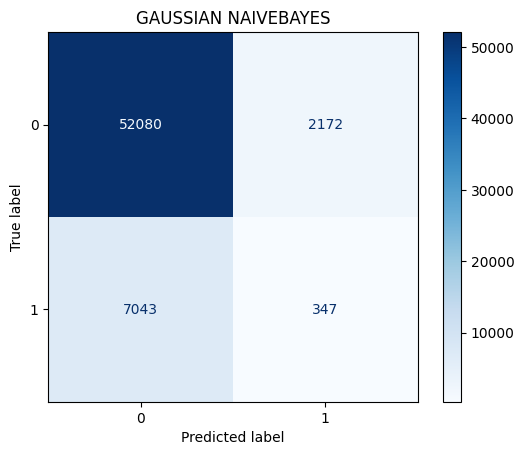


Training DecisionTreeClassifier() ...

PredictingDecisionTreeClassifier() scores ...


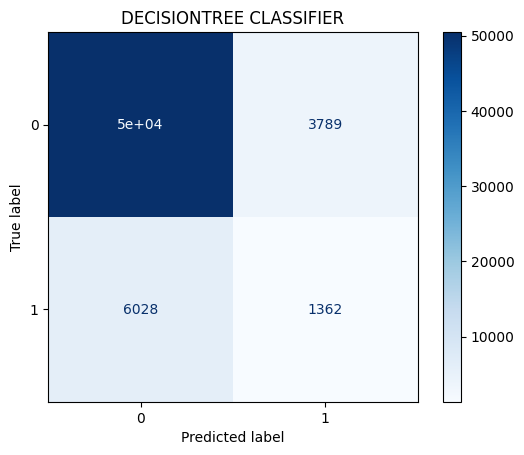


Training RandomForestClassifier() ...

PredictingRandomForestClassifier() scores ...


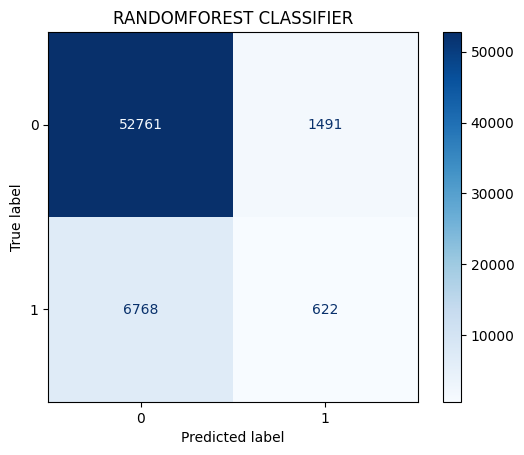


Training GradientBoostingClassifier() ...

PredictingGradientBoostingClassifier() scores ...


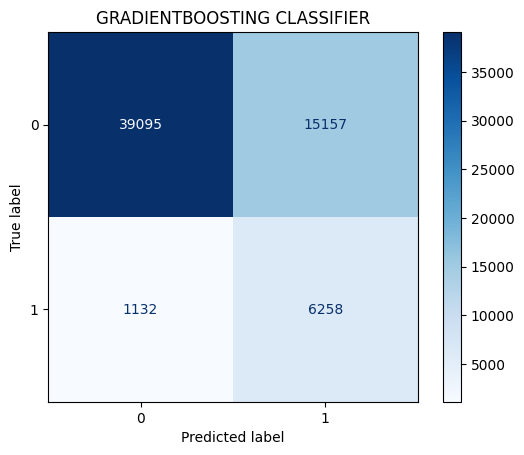


Training BaggingClassifier() ...

PredictingBaggingClassifier() scores ...


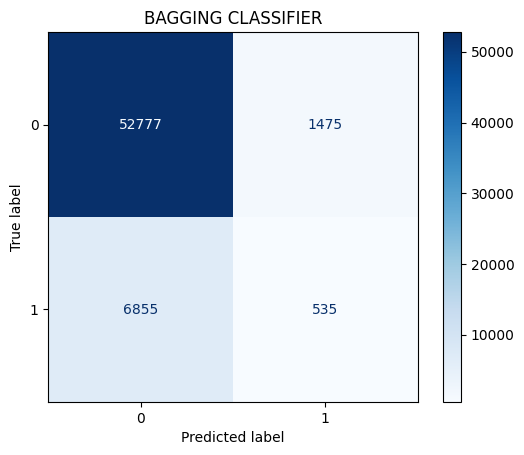


Training XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) ...

PredictingXGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              

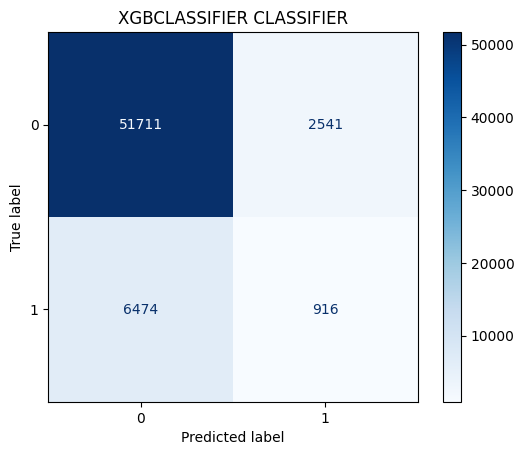


Training AdaBoostClassifier() ...

PredictingAdaBoostClassifier() scores ...


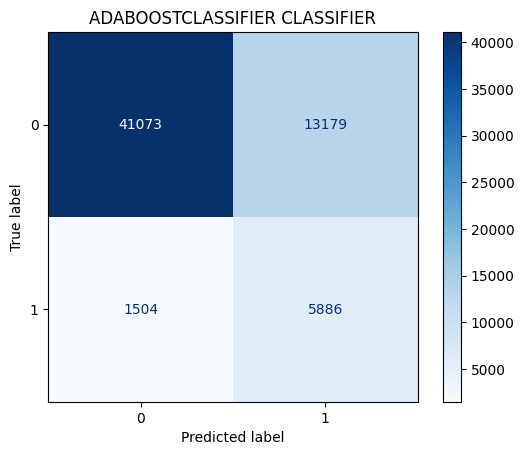


Training <catboost.core.CatBoostClassifier object at 0x000001B42BD4BC40> ...

Predicting<catboost.core.CatBoostClassifier object at 0x000001B42BD4BC40> scores ...


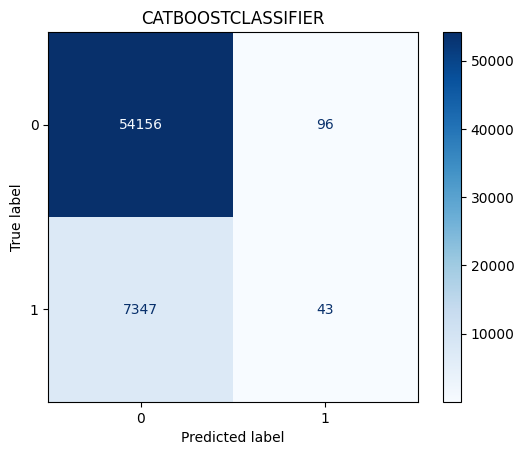


Training LGBMClassifier() ...
[LightGBM] [Info] Number of positive: 212781, number of negative: 212781
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 425562, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

PredictingLGBMClassifier() scores ...


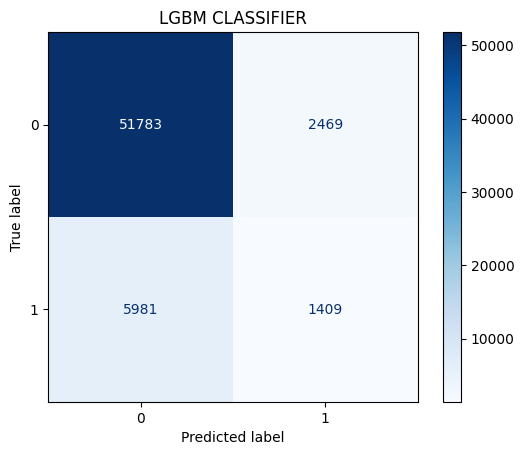

,Sampling,model_name,TP,FP,TN,FN,accuracy,balanced_accuracy,recall,precision,f1,f0.5,f2.0,roc_auc
0,None,Gaussian NaiveBayes,348,2182,52070,7042,0.850362,0.503435,0.047091,0.137549,0.070161,0.099372,0.054222,0.503393
1,None,DecisionTree Classifier,1298,3706,50546,6092,0.841050,0.553666,0.175643,0.259392,0.209456,0.236809,0.187768,0.553666
2,None,RandomForest Classifier,336,677,53575,7054,0.874582,0.516494,0.045467,0.331688,0.079971,0.146827,0.054950,0.805645
3,None,GradientBoosting Classifier,0,1,54251,7390,0.880098,0.499991,0.000000,0.000000,0.000000,0.000000,0.000000,0.846993
4,None,Bagging Classifier,335,746,53506,7055,0.873447,0.515790,0.045332,0.309898,0.079093,0.142991,0.054665,0.723983
5,None,XGBClassifier Classifier,23,65,54187,7367,0.879433,0.500957,0.003112,0.261364,0.006151,0.014854,0.003879,0.816254
6,None,AdaBoostClassifier Classifier,0,0,54252,7390,0.880114,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.851738
7,None,CatBoostClassifier,23,47,54205,7367,0.879725,0.501123,0.003112,0.328571,0.006166,0.014993,0.003881,0.824994
8,None,LGBM Classifier,0,7,54245,7390,0.880001,0.499935,0.000000,0.000000,0.000000,0.000000,0.000000,0.817112
9,SMOTE Sampling,Gaussian NaiveBayes,345,2116,52136,7045,0.851384,0.503841,0.046685,0.140187,0.070044,0.100093,0.053871,0.504199


In [9]:
# Smoteek sampled

X_smote, y_smote = do_sampling(X_train, y_train, SMOTETomek)

models, names = get_models()
for i in range(len(models)):
  evaluate("SMOTEEK Sampling", names[i],models[i],X_smote, y_smote, X_test,y_test)
display_report()

In [10]:
final_report = display_report()

In [11]:
final_report.sort_values([ 'f2.0'], ascending = False).head(5)

,Sampling,model_name,TP,FP,TN,FN,accuracy,balanced_accuracy,recall,precision,f1,f0.5,f2.0,roc_auc
21,SMOTEen Sampling,GradientBoosting Classifier,6411,15618,38634,979,0.730752,0.789822,0.867524,0.291025,0.435841,0.335633,0.621353,0.840221
24,SMOTEen Sampling,AdaBoostClassifier Classifier,6216,14580,39672,1174,0.744428,0.786195,0.841137,0.298904,0.441070,0.343145,0.617205,0.846172
30,SMOTEEK Sampling,GradientBoosting Classifier,6258,15157,39095,1132,0.735748,0.783719,0.846820,0.292225,0.434508,0.336271,0.613830,0.843497
15,SMOTE Sampling,AdaBoostClassifier Classifier,5932,13211,41041,1458,0.762029,0.779597,0.802706,0.309878,0.447141,0.353255,0.608997,0.843344
33,SMOTEEK Sampling,AdaBoostClassifier Classifier,5886,13179,41073,1504,0.761802,0.776780,0.796482,0.308733,0.444982,0.351823,0.605244,0.846120


In [12]:
a = final_report.copy()
a['Name'] = a['Sampling'] + a['model_name']

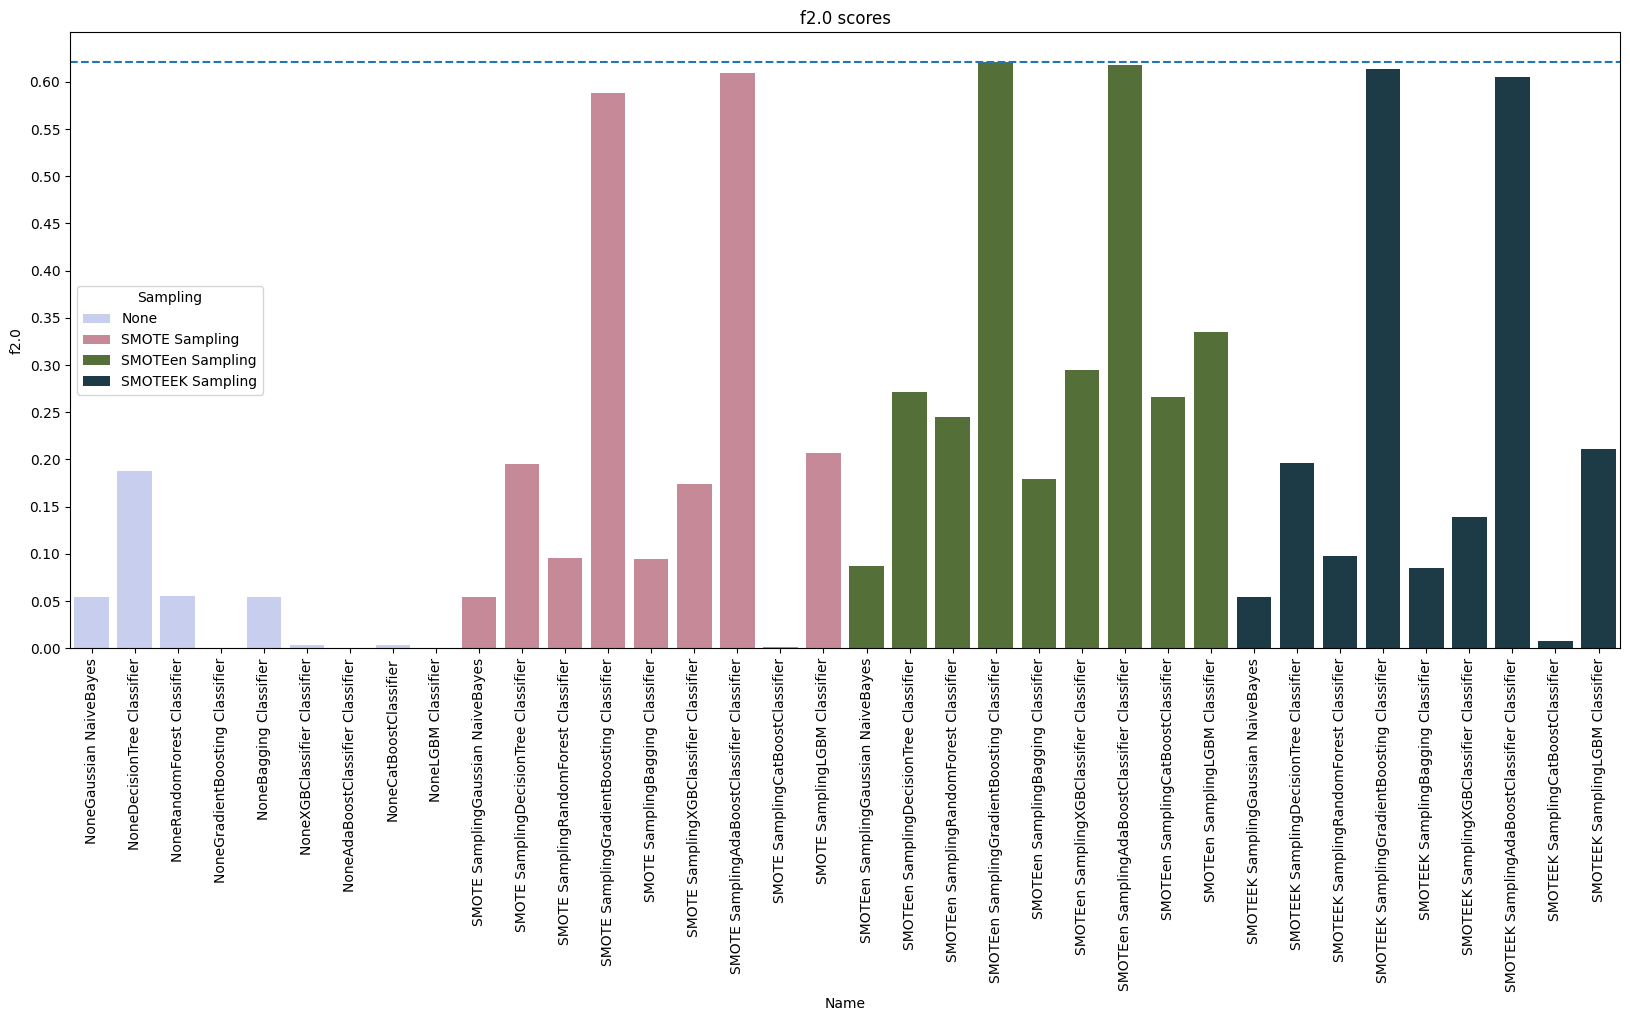

In [13]:
metrics = ['f2.0']
for i in metrics:
  print('\n')
  plt.figure(figsize = (20,8))
  sns.barplot( y = i, x = 'Name',hue = 'Sampling' ,data=a, palette = 'cubehelix_r',dodge=False)
  plt.yticks(ticks = np.arange(0,final_report[i].max(), .05 ))
  plt.xticks(rotation =90)
  plt.axhline(y = final_report[i].max(), ls = '--')
  plt.title(f"{i} scores")
  plt.show()


If maximizing precision minimizes false positives, and maximizing recall minimizes false negatives, then the F2-measure puts more attention on minimizing false negatives than minimizing false positives.

Here minimizing false negatives is important because it means that the insurance company is losing on potential customers. Therefore, it would be smart to look for a metric that focuses on reducing false negatives more. Hence, F2 score could potentially be a good metric

Best performing models


1.   **SMOTEEN sampled GradientBoosting Classifier**
2.   **SMOTEENN sampled AdaBoostClassifier Classifier**
3.   **SMOTEEK sampled GradientBoosting Classifier**


### Fine Tuning

In [25]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
import mlflow


def objective(trial):

    # ================================
    # 1. CHOOSE DATASET VARIANT
    # ================================
    data_variant = trial.suggest_categorical(
        "data_variant", ["SMOTEENN", "SMOTEEK"]
    )

    dataset_map = {
        "SMOTEENN": (X_train2, y_train2),
        "SMOTEEK": (X_train1, y_train1)
    }

    X_train, y_train = dataset_map[data_variant]

    # ================================
    # 2. CHOOSE MODEL
    # ================================
    model_type = trial.suggest_categorical(
        "model_type", ["GradientBoosting", "AdaBoost"]
    )

    with mlflow.start_run(nested=True):

        mlflow.log_param("model_type", model_type)
        mlflow.log_param("data_variant", data_variant)

        # ================================
        # 3. MODEL-SPECIFIC TUNING
        # ================================

        if model_type == "GradientBoosting":
            params = {
                "n_estimators": trial.suggest_int("gb_n_estimators", 100, 1000),
                "learning_rate": trial.suggest_float("gb_lr", 0.01, 0.2, log=True),
                "max_depth": trial.suggest_int("gb_max_depth", 3, 10),
                "subsample": trial.suggest_float("gb_subsample", 0.7, 1.0),
                "random_state": 42
            }
            model = GradientBoostingClassifier(**params)

        elif model_type == "AdaBoost":
            params = {
                "n_estimators": trial.suggest_int("ada_n_estimators", 50, 500),
                "learning_rate": trial.suggest_float("ada_lr", 0.01, 1.0, log=True),
                "random_state": 42
            }
            model = AdaBoostClassifier(**params)

        # ================================
        # 4. TRAIN & EVALUATE
        # ================================

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_macro = f1_score(y_test, y_pred, average="macro")
        recall_risk = recall_score(y_test, y_pred)

        # ================================
        # 5. LOG METRICS
        # ================================

        mlflow.log_params(params)
        mlflow.log_metrics({
            "f1_macro": f1_macro,
            "recall_risk": recall_risk
        })

        return f1_macro


In [26]:
import optuna
import mlflow

mlflow.set_tracking_uri(
    r"file:///C:\Users\user\Desktop\ML & DL projects\2 Stage loan system\mlruns"
)

mlflow.set_experiment("boosting_models_prebalanced_data")

study = optuna.create_study(direction="maximize")

with mlflow.start_run(run_name="Hyperparameter_Sweep_PreBalanced"):

    mlflow.log_param("n_trials", 30)
    mlflow.log_param("data_sources", "SMOTEENN_SMOTEEK")

    study.optimize(objective, n_trials=30)

    # ✅ LOG BEST EVERYTHING
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_f1_macro", study.best_value)

    mlflow.set_tag("stage", "model_selection")
    mlflow.set_tag("optimized_models", "GradientBoosting_AdaBoost")
    mlflow.set_tag("optimized_datasets", "SMOTEENN_SMOTEEK")


# ================================
# RESULTS SUMMARY
# ================================

best_params = study.best_params

model_type = best_params["model_type"]
data_variant = best_params["data_variant"]

print("=" * 45)
print("   OPTIMIZATION COMPLETE")
print("=" * 45)

print(f"Best Dataset Variant: {data_variant}")
print(f"Best Model:           {model_type}")
print(f"Best F1-Macro:        {study.best_value:.4f}")

print("-" * 45)
print("Best Hyperparameters:")

for k, v in best_params.items():
    if k not in ["model_type", "data_variant"]:
        print(f"  {k}: {v}")

print("=" * 45)


[I 2026-02-13 21:28:37,607] A new study created in memory with name: no-name-e45213b2-90a1-4da0-8393-d23a709de650
[I 2026-02-13 21:34:08,406] Trial 0 finished with value: 0.5172536380049828 and parameters: {'data_variant': 'SMOTEENN', 'model_type': 'GradientBoosting', 'gb_n_estimators': 486, 'gb_lr': 0.1911523097200001, 'gb_max_depth': 10, 'gb_subsample': 0.7314503581781455}. Best is trial 0 with value: 0.5172536380049828.
[I 2026-02-13 21:34:41,489] Trial 1 finished with value: 0.656171951171997 and parameters: {'data_variant': 'SMOTEEK', 'model_type': 'AdaBoost', 'ada_n_estimators': 323, 'ada_lr': 0.07195545885839211}. Best is trial 1 with value: 0.656171951171997.
[I 2026-02-13 21:40:43,339] Trial 2 finished with value: 0.4890463143406441 and parameters: {'data_variant': 'SMOTEENN', 'model_type': 'GradientBoosting', 'gb_n_estimators': 607, 'gb_lr': 0.06721181263510279, 'gb_max_depth': 9, 'gb_subsample': 0.7357857704578088}. Best is trial 1 with value: 0.656171951171997.
[I 2026-02-1

   OPTIMIZATION COMPLETE
Best Dataset Variant: SMOTEEK
Best Model:           AdaBoost
Best F1-Macro:        0.6604
---------------------------------------------
Best Hyperparameters:
  ada_n_estimators: 242
  ada_lr: 0.019650455115780504


In [28]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
import mlflow
import joblib

# ================================
# 1. DATASET REGISTRY (plug & play)
# ================================

dataset_map = {
    "SMOTEEN": (X_train2, y_train2),
    "SMOTEEK": (X_train1, y_train1),
    "RAW": (X_train, y_train)   # optional if you want original too
}

# ================================
# 2. MODEL REGISTRY
# ================================

def build_model(model_type, params):

    if model_type == "GradientBoosting":
        mapping = {
            "gb_lr": "learning_rate",
            "gb_n_estimators": "n_estimators",
            "gb_max_depth": "max_depth",
            "gb_subsample": "subsample"
        }
        clean = {mapping.get(k, k): v for k, v in params.items()}
        return GradientBoostingClassifier(**clean, random_state=42)

    if model_type == "RandomForest":
        mapping = {
            "rf_n_estimators": "n_estimators",
            "rf_max_depth": "max_depth",
            "rf_split": "min_samples_split",
            "rf_feat": "max_features"
        }
        clean = {mapping.get(k, k): v for k, v in params.items()}
        return RandomForestClassifier(**clean, n_jobs=-1, random_state=42)

    if model_type == "XGBoost":
        mapping = {
            "xgb_lr": "learning_rate",
            "xgb_n_estimators": "n_estimators",
            "xgb_max_depth": "max_depth",
            "xgb_gamma": "gamma"
        }
        clean = {mapping.get(k, k): v for k, v in params.items()}
        return xgb.XGBClassifier(**clean, random_state=42, eval_metric="logloss")

    if model_type == "AdaBoost":
        mapping = {
            "ada_lr": "learning_rate",
            "ada_n_estimators": "n_estimators"
        }
        clean = {mapping.get(k, k): v for k, v in params.items()}
        return AdaBoostClassifier(**clean, random_state=42)

    raise ValueError(f"Unknown model: {model_type}")


# ================================
# 3. EXTRACT BEST SETTINGS
# ================================

best_params = study.best_params.copy()

model_type = best_params.pop("model_type")
dataset_type = best_params.pop("data_variant")
  # you optimized this earlier

X_train_final, y_train_final = dataset_map[dataset_type]

print(f"Using Dataset: {dataset_type}")
print(f"Using Model: {model_type}")

# ================================
# 4. BUILD & TRAIN MODEL
# ================================

best_model = build_model(model_type, best_params)

print("\nTraining final model...")
best_model.fit(X_train_final, y_train_final)

# ================================
# 5. EVALUATION
# ================================

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
recall_risk = recall_score(y_test, y_pred)

print("\n===== FINAL PERFORMANCE =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"Recall (Risk Class): {recall_risk:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# ================================
# 6. SAVE MODEL LOCALLY
# ================================

model_path = f"best_model_{model_type}_{dataset_type}.pkl"
joblib.dump(best_model, model_path)

print(f"\nModel saved as: {model_path}")


# ================================
# 7. LOG TO MLFLOW
# ================================

with mlflow.start_run(run_name=f"final_{model_type}_{dataset_type}"):

    mlflow.log_param("model_type", model_type)
    mlflow.log_param("dataset_variant", dataset_type)
    mlflow.log_params(best_params)

    mlflow.log_metrics({
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "recall_risk": recall_risk
    })

    if model_type == "XGBoost":
        mlflow.xgboost.log_model(best_model, "model")
    else:
        mlflow.sklearn.log_model(best_model, "model")

print("\n✅ Training + logging complete!")


Using Dataset: SMOTEEK
Using Model: AdaBoost

Training final model...


2026/02/13 22:41:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



===== FINAL PERFORMANCE =====
Accuracy: 0.7929
F1 Macro: 0.6604
Recall (Risk Class): 0.7015

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87     54252
           1       0.33      0.70      0.45      7390

    accuracy                           0.79     61642
   macro avg       0.64      0.75      0.66     61642
weighted avg       0.88      0.79      0.82     61642


Model saved as: best_model_AdaBoost_SMOTEEK.pkl

✅ Training + logging complete!
